In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import requests

from datetime import datetime
import time
import os

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [7]:
# 코인 리스트 받아오기
url = 'https://api.upbit.com/v1/market/all?isDetails=true'

headers = {"accept": "application/json"}
res = requests.get(url, headers=headers)

df = pd.DataFrame(res.json())
df = df.loc[df['market'].str.contains('KRW')]
df['market'] = df['market'].str.strip('KRW-')
coinlist = list(df['market'])
coinlist

['BTC',
 'ETH',
 'NEO',
 'MTL',
 'XRP',
 'ETC',
 'SNT',
 'AVES',
 'XEM',
 'QTUM',
 'LS',
 'STEEM',
 'XLM',
 'ARD',
 'A',
 'STORJ',
 'GRS',
 'ADA',
 'SBD',
 'PO',
 'BTG',
 'ICX',
 'EOS',
 'TRX',
 'SC',
 'ONT',
 'ZIL',
 'POLYX',
 'ZRX',
 'LOOM',
 'BCH',
 'BAT',
 'IOST',
 'CVC',
 'IQ',
 'IOTA',
 'HIFI',
 'ONG',
 'GAS',
 'UPP',
 'ELF',
 'NC',
 'BSV',
 'THETA',
 'QKC',
 'BTT',
 'MOC',
 'TFUEL',
 'MANA',
 'AN',
 'AERGO',
 'ATOM',
 'TT',
 'GAME2',
 'MBL',
 'AXP',
 'HBA',
 'MED',
 'ML',
 'STPT',
 'ORBS',
 'VET',
 'CHZ',
 'STMX',
 'DKA',
 'HIVE',
 'AVA',
 'AHT',
 'LIN',
 'XTZ',
 'BORA',
 'JST',
 'CRO',
 'TON',
 'SXP',
 'HUNT',
 'DOT',
 'MVL',
 'STRAX',
 'AQT',
 'GLM',
 'META',
 'FCT2',
 'CB',
 'SAND',
 'HPO',
 'DOGE',
 'STRIKE',
 'PUNDIX',
 'FLO',
 'AXS',
 'STX',
 'XEC',
 'SOL',
 'MATIC',
 'AAVE',
 '1INCH',
 'ALGO',
 'NEA',
 'AVAX',
 'T',
 'CELO',
 'GMT',
 'APT',
 'SHIB',
 'MAS',
 'ARB',
 'EGLD',
 'SUI',
 'GRT',
 'BLU',
 'IMX',
 'SEI',
 'MINA',
 'CTC',
 'AST',
 'ID',
 'PYTH',
 'MNT',
 'AKT',
 '

In [8]:
# 코인 별 파일 받아와서 하나의 데이터 프레임으로 합치기
dfs = []

for coin in coinlist:
    file_name = f'coin_1day/upbit_{coin}_prices_2023_days.csv'
    # df = pd.read_csv(file_name).drop('Unnamed: 0', axis=1)
    
    if os.path.exists(file_name):
        df = pd.read_csv(file_name).drop('Unnamed: 0', axis=1)
    else:
        continue
        
    # 빈 파일이 있다.
    if len(df) != 0:
        condition = (df['candle_date_time_utc'] >= '2022-12-31') & (df['candle_date_time_utc'] <= '2023-12-31')
        df = df[condition]
    dfs.append(df)
    
df_coins = pd.concat(dfs, ignore_index=True)
df_coins.head()

,market,candle_date_time_utc,candle_date_time_kst,opening_price,high_price,low_price,trade_price,timestamp,candle_acc_trade_price,candle_acc_trade_volume,prev_closing_price,change_price,change_rate
0,KRW-BTC,2022-12-31,2022-12-31T09:00:00,21086000.0,21249000.0,20966000.0,21079000.0,1672531199722,6.253054e+10,2960.900095,21070000.0,9000.0,0.000427
1,KRW-BTC,2023-01-01,2023-01-01T09:00:00,21079000.0,21171000.0,21002000.0,21123000.0,1672617597561,3.135794e+10,1486.467553,21079000.0,44000.0,0.002087
2,KRW-BTC,2023-01-02,2023-01-02T09:00:00,21128000.0,21400000.0,21047000.0,21215000.0,1672703999647,5.484883e+10,2578.844531,21123000.0,92000.0,0.004355
3,KRW-BTC,2023-01-03,2023-01-03T09:00:00,21209000.0,21451000.0,21178000.0,21351000.0,1672790398972,4.477008e+10,2097.615306,21215000.0,136000.0,0.006411
4,KRW-BTC,2023-01-04,2023-01-04T09:00:00,21351000.0,21732000.0,21341000.0,21588000.0,1672876797009,5.338029e+10,2479.248182,21351000.0,237000.0,0.011100


In [9]:
# 코인 이름에 KRW 제거
df_coins['market'] = df_coins['market'].str[4:]

In [10]:
# 전일 거래대금에 비해 2배 이상 급등하는 조건으로 데이터 추출
df_coins.loc[df_coins['candle_acc_trade_price'] > 2 * df_coins['candle_acc_trade_price'].shift(), 'double_up'] = True
df_coins = df_coins[df_coins['candle_date_time_utc'] >= '2023-01-01']
df_coins

,market,candle_date_time_utc,candle_date_time_kst,opening_price,high_price,low_price,trade_price,timestamp,candle_acc_trade_price,candle_acc_trade_volume,prev_closing_price,change_price,change_rate,double_up
1,BTC,2023-01-01,2023-01-01T09:00:00,21079000.0,21171000.0,21002000.0,21123000.0,1672617597561,3.135794e+10,1.486468e+03,21079000.0,44000.0,0.002087,NaN
2,BTC,2023-01-02,2023-01-02T09:00:00,21128000.0,21400000.0,21047000.0,21215000.0,1672703999647,5.484883e+10,2.578845e+03,21123000.0,92000.0,0.004355,NaN
3,BTC,2023-01-03,2023-01-03T09:00:00,21209000.0,21451000.0,21178000.0,21351000.0,1672790398972,4.477008e+10,2.097615e+03,21215000.0,136000.0,0.006411,NaN
4,BTC,2023-01-04,2023-01-04T09:00:00,21351000.0,21732000.0,21341000.0,21588000.0,1672876797009,5.338029e+10,2.479248e+03,21351000.0,237000.0,0.011100,NaN
5,BTC,2023-01-05,2023-01-05T09:00:00,21589000.0,21641000.0,21404000.0,21575000.0,1672963199288,7.670565e+10,3.563010e+03,21588000.0,-13000.0,-0.000602,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33899,GRT,2023-12-27,2023-12-27T09:00:00,267.0,272.0,247.0,255.0,1703721574638,1.193789e+10,4.663414e+07,267.0,-12.0,-0.044944,NaN
33900,GRT,2023-12-28,2023-12-28T09:00:00,255.0,270.0,251.0,252.0,1703807993131,2.118269e+10,8.125003e+07,255.0,-3.0,-0.011765,NaN
33901,GRT,2023-12-29,2023-12-29T09:00:00,252.0,256.0,239.0,244.0,1703894399963,1.324197e+10,5.378081e+07,252.0,-8.0,-0.031746,NaN
33902,GRT,2023-12-30,2023-12-30T09:00:00,244.0,245.0,235.0,240.0,1703980761535,5.955023e+09,2.481044e+07,244.0,-4.0,-0.016393,NaN


In [11]:
# timestamp 형식으로 바꿔서 새로운 열 만들기
df_coins['timestamp_utc'] = pd.to_datetime(df_coins['candle_date_time_utc'])
df_coins['timestamp_utc'] = df_coins['timestamp_utc'].apply(lambda x: x.timestamp())

In [12]:
# merge를 위한 데이터 프레임을 만든다.
for_concat = pd.DataFrame([1]*365)
for_concat.index = df_coins['timestamp_utc'].unique()
for_concat.index.name = 'timestamp_utc'
for_concat.reset_index(inplace=True)
for_concat

,timestamp_utc,0
0,1.672531e+09,1
1,1.672618e+09,1
2,1.672704e+09,1
3,1.672790e+09,1
4,1.672877e+09,1
...,...,...
360,1.703635e+09,1
361,1.703722e+09,1
362,1.703808e+09,1
363,1.703894e+09,1


In [13]:
# 전일에 비해 거래대금이 2배 이상 상승한 코인들을 코인 이름 기준으로 시간을 묶어 timestamp 형식의 벡터를 거리계산해 가까운지 계산
grouped_df = df_coins[df_coins['double_up'] == True].groupby('market')['timestamp_utc']

merged = for_concat
for name, group in grouped_df:
    temp = group.to_frame()
    temp[f'{name}'] = 1
    merged = merged.merge(temp, on='timestamp_utc', how='left')

merged = merged.fillna(0)
merged

,timestamp_utc,0,1INCH,AAVE,ADA,AERGO,AHT,ALGO,APT,AQT,...,TT,UPP,VET,XEC,XEM,XLM,XRP,XTZ,ZIL,ZRX
0,1.672531e+09,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.672618e+09,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.672704e+09,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.672790e+09,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.672877e+09,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,1.703635e+09,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
361,1.703722e+09,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
362,1.703808e+09,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363,1.703894e+09,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [14]:
def cal_distance(df_features):
    # df_features = merged.loc[:, '1INCH':]
    
    # 열들 간의  거리 계산
    distance_matrix = pdist(df_features.T, metric='euclidean') # cosine
    
    # 계층적 군집 분석 수행
    linked = linkage(distance_matrix, method='ward')
    return linked

In [15]:
df_features = merged.loc[:, '1INCH':]
linked = cal_distance(df_features)

In [16]:
# 덴드로그램 시각화
def plot_dendrogram(linked):
    plt.figure(figsize=(20, 10))
    plt.rc('font', size=17)
    dendrogram(linked, labels=df_features.columns)
    plt.title('Dendrogram for Coin Clustering')
    plt.xlabel('Coins')
    plt.ylabel('Euclidean Distance')
    plt.xticks(fontsize=13)
    plt.show()

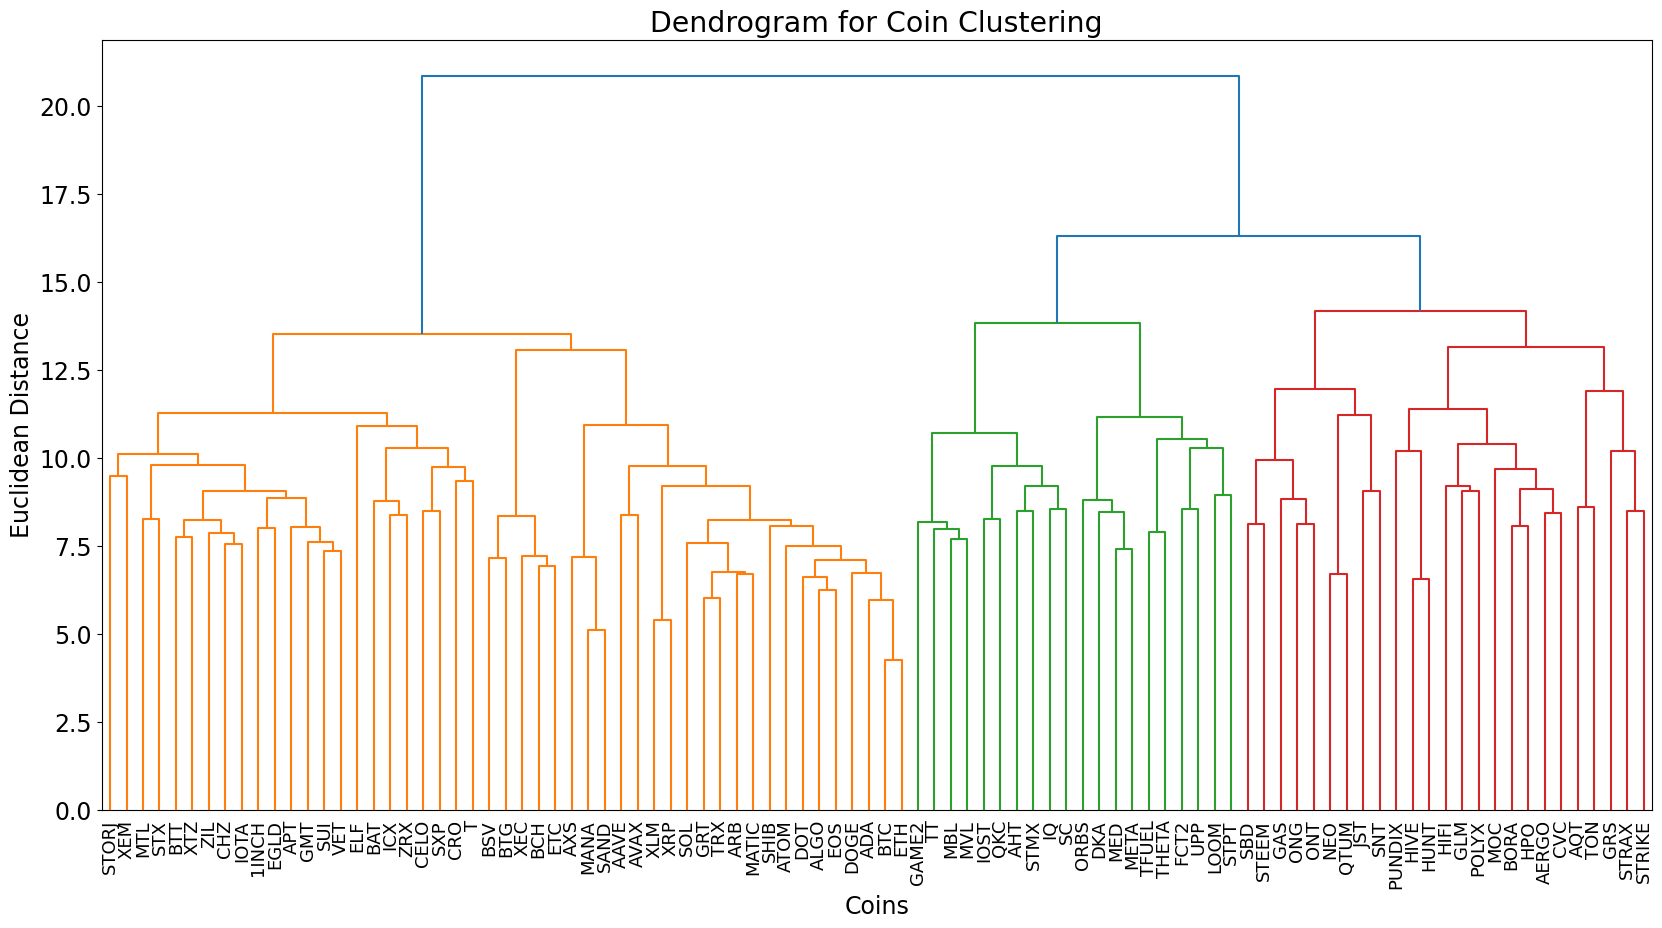

In [17]:
plot_dendrogram(linked)

In [18]:
# 실제로 겹치는 날짜 개수 확인
def check_ups(coin1, coin2):
    up_coins = df_coins[df_coins['double_up'] == True]
    count = 0
    coin1_ups = up_coins[up_coins['market'] == coin1].candle_date_time_utc.values
    coin2_ups = up_coins[up_coins['market'] == coin2].candle_date_time_utc.values
    for value in coin1_ups:
        if value in coin2_ups:
            count += 1
            
    print(f"{coin1} 상승한 일 수 : {len(coin1_ups)}")
    print(f"{coin2} 상승한 일 수 : {len(coin2_ups)}")
    print(f"상승한 날 겹치는 일 수 : {count}")

In [19]:
check_ups('NEO', 'QTUM')

NEO 상승한 일 수 : 69
QTUM 상승한 일 수 : 66
상승한 날 겹치는 일 수 : 45


In [20]:
def cluster_result(linked, df_features, num):
    # 원하는 군집 수 설정
    num_clusters = num
    
    # fcluster 함수를 사용하여 군집화
    clusters = fcluster(linked, num_clusters, criterion='maxclust')
    
    # 군집 결과를 데이터프레임으로 저장
    clustered_coins = pd.DataFrame({'Coin': df_features.columns, 'Cluster': clusters})
    
    # 각 군집의 요소를 확인
    for cluster_num in range(1, num_clusters + 1):
        print(f"Cluster {cluster_num}:")
        print(clustered_coins[clustered_coins['Cluster'] == cluster_num]['Coin'].tolist())

    return clustered_coins

In [21]:
clustered_coins = cluster_result(linked, df_features, 80)

Cluster 1:
['STORJ']
Cluster 2:
['XEM']
Cluster 3:
['MTL']
Cluster 4:
['STX']
Cluster 5:
['BTT']
Cluster 6:
['XTZ']
Cluster 7:
['CHZ']
Cluster 8:
['IOTA']
Cluster 9:
['ZIL']
Cluster 10:
['1INCH']
Cluster 11:
['EGLD']
Cluster 12:
['SUI']
Cluster 13:
['VET']
Cluster 14:
['GMT']
Cluster 15:
['APT']
Cluster 16:
['ICX']
Cluster 17:
['ZRX']
Cluster 18:
['BAT']
Cluster 19:
['CELO']
Cluster 20:
['SXP']
Cluster 21:
['CRO']
Cluster 22:
['T']
Cluster 23:
['ELF']
Cluster 24:
['BSV']
Cluster 25:
['BTG']
Cluster 26:
['BCH', 'ETC']
Cluster 27:
['XEC']
Cluster 28:
['MANA', 'SAND']
Cluster 29:
['AXS']
Cluster 30:
['AAVE']
Cluster 31:
['AVAX']
Cluster 32:
['XLM', 'XRP']
Cluster 33:
['ARB', 'GRT', 'MATIC', 'TRX']
Cluster 34:
['SOL']
Cluster 35:
['ADA', 'ALGO', 'BTC', 'DOGE', 'DOT', 'EOS', 'ETH']
Cluster 36:
['ATOM']
Cluster 37:
['SHIB']
Cluster 38:
['MBL']
Cluster 39:
['MVL']
Cluster 40:
['TT']
Cluster 41:
['GAME2']
Cluster 42:
['IOST']
Cluster 43:
['QKC']
Cluster 44:
['AHT']
Cluster 45:
['STMX']
Cluster

## 아래는 가격 간 상관관계 계산

In [213]:
df_pivot = df_coins.pivot_table(index='candle_date_time_utc', columns='market', values='trade_price')
df_pivot

market,1INCH,AAVE,ADA,AERGO,AHT,ALGO,APT,AQT,ARB,ATOM,...,TT,UPP,VET,XEC,XEM,XLM,XRP,XTZ,ZIL,ZRX
candle_date_time_utc,,,,,,,,,,,,,,,,,,,,,
2023-01-01,491.0,66260.0,318.0,114.0,5.50,226.0,4475.0,933.0,NaN,12030.0,...,3.97,58.7,20.4,0.0281,36.6,92.1,431.0,914.0,20.8,192.0
2023-01-02,504.0,67440.0,322.0,116.0,5.55,229.0,4780.0,929.0,NaN,12480.0,...,3.99,59.1,20.6,0.0284,37.3,93.8,443.0,940.0,21.1,198.0
2023-01-03,497.0,67860.0,323.0,115.0,5.54,236.0,4895.0,920.0,NaN,13000.0,...,3.96,59.3,20.7,0.0281,37.2,94.1,440.0,964.0,21.2,198.0
2023-01-04,507.0,72640.0,342.0,116.0,5.65,239.0,4895.0,926.0,NaN,13070.0,...,4.03,59.8,21.2,0.0302,37.4,94.6,445.0,985.0,21.7,203.0
2023-01-05,500.0,71030.0,345.0,116.0,5.67,235.0,4745.0,916.0,NaN,12920.0,...,4.09,61.7,20.9,0.0317,37.2,93.4,433.0,976.0,21.7,203.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,597.0,149400.0,843.0,206.0,10.40,305.0,13530.0,1965.0,2005.0,15940.0,...,6.75,103.0,49.2,0.0538,54.8,175.0,847.0,1485.0,36.2,482.0
2023-12-28,571.0,158950.0,823.0,201.0,10.20,313.0,12870.0,1930.0,1960.0,15230.0,...,6.80,101.0,47.4,0.0510,52.1,177.0,847.0,1410.0,34.6,497.0
2023-12-29,578.0,151050.0,816.0,200.0,10.30,304.0,13000.0,1915.0,2030.0,14750.0,...,6.67,100.0,47.0,0.0504,51.3,174.0,836.0,1385.0,33.9,492.0


In [215]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# 데이터프레임의 값을 스케일링
scaled_data = scaler.fit_transform(df_pivot)

# 스케일링된 데이터를 새로운 데이터프레임으로 변환
scaled_df = pd.DataFrame(scaled_data, columns=df_pivot.columns)
scaled_df

market,1INCH,AAVE,ADA,AERGO,AHT,ALGO,APT,AQT,ARB,ATOM,...,TT,UPP,VET,XEC,XEM,XLM,XRP,XTZ,ZIL,ZRX
0,0.315068,0.006857,0.000000,0.000000,0.000000,0.421687,0.000000,0.013139,NaN,0.326540,...,0.005988,0.007055,0.031949,0.091873,0.095238,0.000000,0.000000,0.062441,0.011494,0.000000
1,0.337329,0.019501,0.006623,0.011299,0.005102,0.433735,0.016464,0.010219,NaN,0.368226,...,0.011976,0.014109,0.038339,0.102473,0.110390,0.014298,0.019386,0.087039,0.022989,0.011719
2,0.325342,0.024001,0.008278,0.005650,0.004082,0.461847,0.022672,0.003650,NaN,0.416396,...,0.002994,0.017637,0.041534,0.091873,0.108225,0.016821,0.014540,0.109745,0.026820,0.011719
3,0.342466,0.075217,0.039735,0.011299,0.015306,0.473896,0.022672,0.008029,NaN,0.422881,...,0.023952,0.026455,0.057508,0.166078,0.112554,0.021026,0.022617,0.129612,0.045977,0.021484
4,0.330479,0.057966,0.044702,0.011299,0.017347,0.457831,0.014575,0.000730,NaN,0.408986,...,0.041916,0.059965,0.047923,0.219081,0.108225,0.010934,0.003231,0.121097,0.045977,0.021484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.496575,0.897675,0.869205,0.519774,0.500000,0.738956,0.488799,0.766423,0.817021,0.688745,...,0.838323,0.788360,0.952077,1.000000,0.489177,0.697225,0.672052,0.602649,0.601533,0.566406
361,0.452055,1.000000,0.836093,0.491525,0.479592,0.771084,0.453171,0.740876,0.778723,0.622974,...,0.853293,0.753086,0.894569,0.901060,0.430736,0.714045,0.672052,0.531693,0.540230,0.595703
362,0.464041,0.915354,0.824503,0.485876,0.489796,0.734940,0.460189,0.729927,0.838298,0.578509,...,0.814371,0.735450,0.881789,0.879859,0.413420,0.688814,0.654281,0.508042,0.513410,0.585938
363,0.438356,0.896068,0.811258,0.485876,0.489796,0.710843,0.440216,0.733577,0.804255,0.551644,...,0.793413,0.730159,0.910543,0.939929,0.422078,0.722456,0.652666,0.493851,0.501916,0.583984


In [253]:
scaled_df.corr().iloc[:30, :30]

market,1INCH,AAVE,ADA,AERGO,AHT,ALGO,APT,AQT,ARB,ATOM,AVAX,AXS,BAT,BCH,BORA,BSV,BTC,BTG,BTT,CELO,CHZ,CRO,CVC,DKA,DOGE,DOT,EGLD,ELF,EOS,ETC
market,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1INCH,1.000000,0.385647,0.496817,0.443069,0.513943,0.940494,0.870248,0.384842,0.830052,0.928074,0.402373,0.931446,0.902843,-0.588490,0.923066,0.160965,-0.196361,0.548132,0.536660,0.892354,0.953146,0.498456,0.703504,0.834712,0.651707,0.744955,0.757020,-0.133379,0.959341,0.829260
AAVE,0.385647,1.000000,0.766818,0.888442,0.494270,0.441668,0.378287,0.870049,0.375416,0.406517,0.760487,0.453129,0.609797,0.347680,0.427892,0.789945,0.686305,0.827803,0.548764,0.616685,0.204241,0.888223,0.767838,0.707707,0.751503,0.680714,0.822972,0.642745,0.225512,0.688775
ADA,0.496817,0.766818,1.000000,0.714379,0.432664,0.608081,0.437522,0.714956,0.644877,0.582226,0.955289,0.557244,0.654885,0.022323,0.531525,0.589553,0.616246,0.695085,0.862446,0.644161,0.378367,0.849179,0.645528,0.640316,0.875194,0.886393,0.963018,0.701709,0.418027,0.736427
AERGO,0.443069,0.888442,0.714379,1.000000,0.598873,0.438078,0.406624,0.906153,0.371742,0.424486,0.677353,0.443510,0.662160,0.186361,0.504399,0.605425,0.648452,0.729373,0.445651,0.578046,0.270516,0.884279,0.862066,0.776098,0.750523,0.618732,0.761364,0.593081,0.295414,0.650037
AHT,0.513943,0.494270,0.432664,0.598873,1.000000,0.387424,0.491451,0.733538,0.524563,0.358640,0.341177,0.376707,0.707065,0.026074,0.639973,0.176731,0.353163,0.601781,0.224771,0.528314,0.345174,0.458209,0.668253,0.733382,0.465716,0.518242,0.562155,0.320774,0.476732,0.471680
ALGO,0.940494,0.441668,0.608081,0.438078,0.387424,1.000000,0.839122,0.361867,0.784108,0.946276,0.565694,0.951083,0.860289,-0.557533,0.849002,0.272943,-0.153565,0.583050,0.715940,0.918645,0.902925,0.581539,0.665403,0.780461,0.725025,0.819261,0.908556,0.002014,0.889288,0.840313
APT,0.870248,0.378287,0.437522,0.406624,0.491451,0.839122,1.000000,0.330529,0.875723,0.865617,0.366607,0.907584,0.841228,-0.472693,0.904982,0.104703,-0.157253,0.528155,0.469571,0.846801,0.830735,0.431547,0.623993,0.757146,0.585645,0.700845,0.764293,-0.136190,0.827566,0.733820
AQT,0.384842,0.870049,0.714956,0.906153,0.733538,0.361867,0.330529,1.000000,0.391032,0.327354,0.682154,0.335927,0.628648,0.311696,0.464984,0.598373,0.735073,0.766262,0.437392,0.515779,0.173499,0.840872,0.810477,0.739238,0.676562,0.625045,0.800060,0.691952,0.265447,0.606447
ARB,0.830052,0.375416,0.644877,0.371742,0.524563,0.784108,0.875723,0.391032,1.000000,0.864857,0.526330,0.887263,0.781880,-0.283638,0.843324,0.271178,0.263838,0.507207,0.552772,0.787553,0.799375,0.450329,0.508017,0.643323,0.664786,0.787339,0.704269,0.122270,0.812415,0.803132


In [255]:
scaled_df.corr().iloc[30:60, 30:60]

market,ETH,FCT2,GAME2,GAS,GLM,GMT,GRS,GRT,HIFI,HIVE,HPO,HUNT,ICX,IOST,IOTA,IQ,JST,LOOM,MANA,MATIC,MBL,MED,META,MOC,MTL,MVL,NEO,ONG,ONT,ORBS
market,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ETH,1.000000,0.495084,0.562145,0.604641,0.435005,-0.142196,0.446700,0.965996,0.253768,0.263030,0.144250,0.643657,0.660492,0.379014,0.505151,0.213339,0.631933,0.257135,0.055074,0.013128,0.687616,-0.044667,0.641276,0.495260,0.779734,0.446267,0.699987,0.614523,0.567535,0.530618
FCT2,0.495084,1.000000,0.839925,0.521340,0.815144,0.301777,0.474744,0.541914,0.335165,0.703283,0.591415,0.905283,0.645661,0.670076,0.459093,0.774253,0.790701,0.414131,0.433086,0.476821,0.697403,0.480826,0.740999,0.891340,0.551493,0.790223,0.739554,0.741654,0.730669,0.729486
GAME2,0.562145,0.839925,1.000000,0.639427,0.649515,0.040885,0.665903,0.516143,0.554130,0.422825,0.261471,0.774938,0.431583,0.385489,0.404149,0.569230,0.832288,0.600211,0.170424,0.170408,0.828279,0.135792,0.811423,0.687567,0.724511,0.683609,0.580456,0.752066,0.512303,0.815960
GAS,0.604641,0.521340,0.639427,1.000000,0.527922,0.002200,0.586686,0.668780,0.514935,0.222316,0.137629,0.584689,0.379305,0.260952,0.386532,0.328339,0.780451,0.398712,0.094053,0.093931,0.781220,0.000463,0.761272,0.445326,0.684273,0.506045,0.612283,0.793518,0.449800,0.719135
GLM,0.435005,0.815144,0.649515,0.527922,1.000000,0.647615,0.296706,0.794712,0.220091,0.858211,0.809819,0.817528,0.730123,0.864259,0.706165,0.893020,0.829506,0.174146,0.747365,0.767331,0.715385,0.740657,0.784826,0.800745,0.360458,0.925539,0.797378,0.848174,0.863062,0.749812
GMT,-0.142196,0.301777,0.040885,0.002200,0.647615,1.000000,-0.168990,0.926930,-0.119411,0.760910,0.797628,0.261284,0.363369,0.747238,0.576758,0.774205,0.296197,-0.246596,0.955368,0.904534,0.125510,0.888846,0.244286,0.331919,-0.304679,0.615308,0.369304,0.406917,0.566422,0.210562
GRS,0.446700,0.474744,0.665903,0.586686,0.296706,-0.168990,1.000000,0.345590,0.831398,0.028110,-0.053203,0.454440,0.151607,0.041533,0.290631,0.221260,0.575292,0.474890,-0.096387,-0.111926,0.650535,-0.191487,0.560471,0.346390,0.663135,0.358528,0.347079,0.543554,0.206982,0.521197
GRT,0.965996,0.541914,0.516143,0.668780,0.794712,0.926930,0.345590,1.000000,0.264126,0.778117,0.843134,0.761906,0.898158,0.916091,0.875517,0.765882,0.770242,0.135742,0.954788,0.909175,0.784570,0.813643,0.749936,0.695184,0.738502,0.855713,0.954836,0.837505,0.903751,0.624423
HIFI,0.253768,0.335165,0.554130,0.514935,0.220091,-0.119411,0.831398,0.264126,1.000000,-0.048825,-0.095951,0.298542,0.015304,-0.053344,0.212916,0.163500,0.488684,0.485056,-0.094487,-0.131237,0.547654,-0.208506,0.470905,0.194500,0.503743,0.271202,0.188445,0.453311,0.090122,0.452375


In [256]:
scaled_df.corr().iloc[60:, 60:]

market,POLYX,PUNDIX,QKC,QTUM,SAND,SBD,SC,SHIB,SNT,SOL,STEEM,STMX,STORJ,STPT,STRAX,STRIKE,STX,SUI,SXP,T,TFUEL,THETA,TON,TRX,TT,UPP,VET,XEC,XEM,XLM,XRP,XTZ,ZIL,ZRX
market,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
POLYX,1.000000,0.814503,0.830023,0.744382,0.441239,0.649736,0.587224,0.495804,0.703190,0.503262,0.811109,0.602780,0.582078,0.508618,0.659368,0.751520,0.366082,0.053679,0.287261,0.471129,0.638981,0.651316,0.683122,0.314140,0.768686,0.710634,0.622129,0.610501,0.696917,0.022020,0.111294,0.515890,0.557226,0.676584
PUNDIX,0.814503,1.000000,0.951362,0.914779,0.555241,0.762819,0.754616,0.641892,0.768543,0.566860,0.927767,0.678586,0.692167,0.551401,0.681573,0.933545,0.551732,0.126998,0.438576,0.609552,0.831016,0.838913,0.894109,0.328020,0.886945,0.861653,0.784989,0.748587,0.868675,0.100989,0.184276,0.706741,0.712571,0.817903
QKC,0.830023,0.951362,1.000000,0.907512,0.602652,0.692215,0.721193,0.685842,0.701036,0.505048,0.881359,0.639038,0.594784,0.485889,0.615235,0.927043,0.539063,0.194186,0.445985,0.659723,0.863450,0.839792,0.827426,0.241033,0.855069,0.853270,0.752218,0.750599,0.878302,0.094612,0.159530,0.742912,0.749043,0.770381
QTUM,0.744382,0.914779,0.907512,1.000000,0.503966,0.707840,0.793950,0.571087,0.747327,0.604565,0.873163,0.620791,0.646780,0.516933,0.651232,0.869959,0.725304,0.228834,0.503090,0.554346,0.777746,0.810974,0.860548,0.373290,0.812289,0.814438,0.817537,0.767284,0.826211,0.191547,0.281309,0.686251,0.677896,0.775516
SAND,0.441239,0.555241,0.602652,0.503966,1.000000,0.126106,0.319798,0.895325,0.092314,0.032512,0.342627,-0.016619,0.085098,-0.246927,0.026507,0.699299,0.183233,0.808684,0.325280,0.842645,0.852521,0.824108,0.326992,-0.474139,0.359852,0.248437,0.634901,0.611556,0.810860,-0.492424,-0.466615,0.938308,0.924955,0.202874
SBD,0.649736,0.762819,0.692215,0.707840,0.126106,1.000000,0.827385,0.237625,0.883925,0.856641,0.889340,0.776273,0.906947,0.678019,0.887744,0.617764,0.559361,-0.029520,0.174628,0.125881,0.395311,0.589904,0.860794,0.694866,0.724061,0.759308,0.654217,0.505208,0.555144,0.318520,0.434076,0.255307,0.238069,0.924213
SC,0.587224,0.754616,0.721193,0.793950,0.319798,0.827385,1.000000,0.449811,0.778060,0.849221,0.823294,0.724575,0.847392,0.572849,0.814692,0.666507,0.759252,0.126989,0.347583,0.279158,0.545029,0.738371,0.805302,0.569933,0.746371,0.751596,0.866863,0.651596,0.664261,0.314058,0.381010,0.448694,0.440345,0.822375
SHIB,0.495804,0.641892,0.685842,0.571087,0.895325,0.237625,0.449811,1.000000,0.207339,0.145564,0.441767,0.225484,0.211032,-0.087616,0.153938,0.778306,0.214664,0.389633,0.234711,0.836216,0.874954,0.827456,0.415169,-0.373566,0.547742,0.473071,0.704009,0.682588,0.825578,-0.337452,-0.429013,0.892384,0.871576,0.288424
SNT,0.703190,0.768543,0.701036,0.747327,0.092314,0.883925,0.778060,0.207339,1.000000,0.829027,0.862932,0.821950,0.839209,0.730718,0.883654,0.606374,0.539672,-0.066958,0.201527,0.135511,0.383440,0.531870,0.825032,0.723155,0.748987,0.767664,0.629257,0.531681,0.516769,0.402518,0.516425,0.228881,0.219390,0.857834
